In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Classification Model

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [96]:
df = pd.read_csv('data/habitat-suitability.csv')

In [97]:
df

,Altitude,Distance_from_Human_Paths,Livestock_Density,Vegetation_Diversity_Index,Water_Source_Availability,Human_Disturbance_Index,Slope,Annual_Rainfall,Bamboo_Coverage,Mean_Annual_Temperature,Suitable
0,2023.988261,233.915650,3.340433,0.004449,1,1.047134,23.136856,566.418927,10.931381,11.216333,1
1,3291.571474,202.416726,2.696428,0.011408,0,1.168012,17.124186,284.616720,49.272585,2.867277,0
2,2810.386672,96.885777,4.996221,0.001876,1,1.120357,15.970847,514.922944,75.865653,4.973466,0
3,2517.048665,467.312224,3.367542,0.004580,0,0.826928,17.213960,401.346841,119.316952,6.729508,0
4,1543.241009,323.727725,2.785573,0.009529,1,1.285206,11.712508,697.497700,10.044292,12.016826,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,3086.843174,1047.942515,2.833574,0.007758,0,0.755481,5.319288,278.967119,47.254330,3.012114,0
9996,3174.519437,23.972588,2.331570,0.013979,0,0.896459,17.397050,219.435015,98.759793,4.709172,0
9997,3282.757413,180.986239,2.879215,0.013206,1,0.644769,6.531635,292.940575,92.248487,2.835185,0
9998,2074.473583,292.882361,4.616194,0.001983,0,1.046871,20.329355,508.999587,18.240434,10.360199,1


In [98]:
def classificationModel(labelled_df, seed):

    X = labelled_df.drop('Suitable', axis=1)
    y = labelled_df['Suitable']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    log_reg = LogisticRegression(random_state=seed)
    log_reg.fit(X_train_scaled, y_train)

    y_pred = log_reg.predict(X_test_scaled)

    sample_accuracy = accuracy_score(y_test, y_pred)

    return sample_accuracy, log_reg, scaler

### **Baseline Model** (with full information)

In [99]:
baseline_accuracy = []
for seed in range(1, 11):
    sample_accuracy, _, _ = classificationModel(df, seed=seed)
    baseline_accuracy.append(sample_accuracy)

In [105]:
baseline_accuracy = np.mean(baseline_accuracy)

### **Random Active Learning**

In [101]:
# Average across seeds to get a more robust result:
tot_accuracies = []

for seed in range(1, 11):

    accuracies = {}

    # Initialize sample (stratified)
    not_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])

    step = 50

    for size in range(50, 1000, step):
        
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed)

        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(not_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]
        
        # Get new sample
        new_labels = not_labelled_df.sample(n=step, random_state = seed)

        # Update datasets
        not_labelled_df = not_labelled_df.drop(new_labels.index)
        current_sample = pd.concat([current_sample, new_labels])
        

    tot_accuracies.append(accuracies)

In [106]:
list_of_dicts = tot_accuracies

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

accuracies_df = pd.DataFrame(averages).T
accuracies_df.columns = ['Sample Accuracy', 'Full Accuracy']

In [107]:
all_accuracies_df = pd.DataFrame.from_records(list_of_dicts)

def compute_stats(df, key, element_index=0):
    max_vals = df[key].apply(lambda x: x[element_index]).max()
    min_vals = df[key].apply(lambda x: x[element_index]).min()
    q25_vals = df[key].apply(lambda x: x[element_index]).quantile(0.25)
    q75_vals = df[key].apply(lambda x: x[element_index]).quantile(0.75)
    return max_vals, min_vals, q25_vals, q75_vals

# Compute stats for sample and full accuracy
stats_sample = {size: compute_stats(all_accuracies_df, size, element_index=0) for size in all_accuracies_df.columns}
stats_full = {size: compute_stats(all_accuracies_df, size, element_index=1) for size in all_accuracies_df.columns}

# Convert these stats into DataFrames
stats_sample_df = pd.DataFrame(stats_sample, index=['Max', 'Min', '25%', '75%']).T
stats_full_df = pd.DataFrame(stats_full, index=['Max', 'Min', '25%', '75%']).T

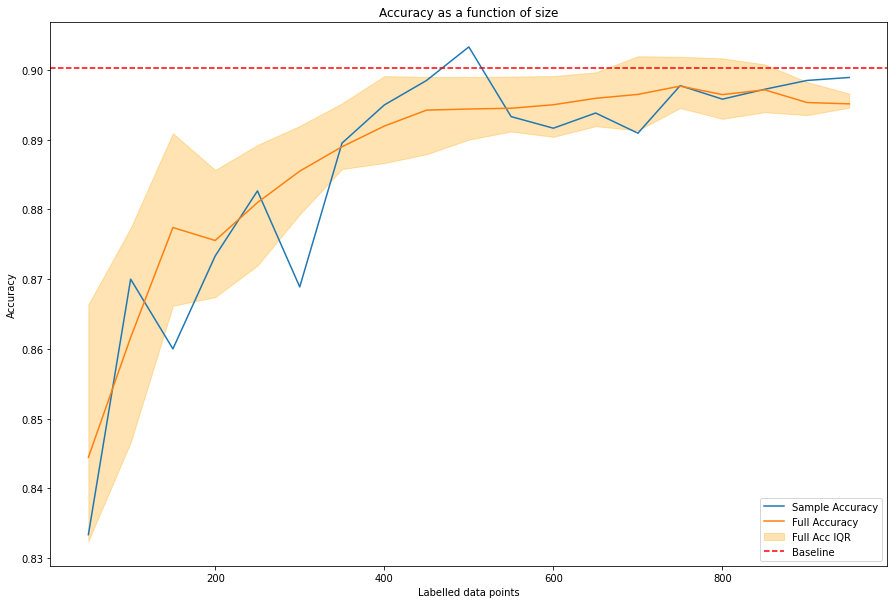

In [108]:
# Plotting
plt.figure(figsize=(15,10))

# Plot average accuracies
plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Sample Accuracy'], label='Sample Accuracy')
plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Full Accuracy'], label='Full Accuracy')

# Optional: Plot IQR
# plt.fill_between(accuracies_df.reset_index()['index'], stats_sample_df['25%'], stats_sample_df['75%'], color='blue', alpha=0.3, label='Sample Acc IQR')
plt.fill_between(accuracies_df.reset_index()['index'], stats_full_df['25%'], stats_full_df['75%'], color='orange', alpha=0.3, label='Full Acc IQR')

# Baseline accuracy and other plot settings
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
plt.legend()
plt.title('Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')
plt.show()

### **Uncertainty Based Active Learning**

In [109]:
tot_accuracies_u = []

for seed in range(1, 11):
    
    non_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    #labelled_indexes = current_sample.index.tolist()
    
    step = 50
    accuracies_u = {}

    for size in range(50, 1000, step):

        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed=seed)

        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(non_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(non_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies_u[size] = [sample_acc, full_acc]
        
        # Update sample  -- Uncertainty based
        predicted_proba = model.predict_proba(full_X_train_scaled)
        predicted_proba_df = pd.DataFrame(predicted_proba[:,1], index=non_labelled_df.index)
        predicted_proba_df['uncertainty_diff'] = (0.5 - predicted_proba_df[0]).abs()
        top_50_uncertain_points = predicted_proba_df.nsmallest(step, 'uncertainty_diff')

        to_be_labelled = non_labelled_df.loc[top_50_uncertain_points.index]

        # Update labelled_indexes with the indexes of the top 50 uncertain points
        current_sample = pd.concat([current_sample, to_be_labelled])
        non_labelled_df = non_labelled_df.drop(top_50_uncertain_points.index)

    tot_accuracies_u.append(accuracies_u)

In [110]:
list_of_dicts = tot_accuracies_u

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

accuracies_u_df = pd.DataFrame(averages).T
accuracies_u_df.columns = ['Sample Accuracy', 'Full Accuracy']

In [111]:
all_accuracies_u_df = pd.DataFrame.from_records(list_of_dicts)

def compute_stats(df, key, element_index=0):
    max_vals = df[key].apply(lambda x: x[element_index]).max()
    min_vals = df[key].apply(lambda x: x[element_index]).min()
    q25_vals = df[key].apply(lambda x: x[element_index]).quantile(0.25)
    q75_vals = df[key].apply(lambda x: x[element_index]).quantile(0.75)
    return max_vals, min_vals, q25_vals, q75_vals

# Compute stats for sample and full accuracy
stats_sample = {size: compute_stats(all_accuracies_u_df, size, element_index=0) for size in all_accuracies_u_df.columns}
stats_full = {size: compute_stats(all_accuracies_u_df, size, element_index=1) for size in all_accuracies_u_df.columns}

# Convert these stats into DataFrames
stats_sample_u_df = pd.DataFrame(stats_sample, index=['Max', 'Min', '25%', '75%']).T
stats_full_u_df = pd.DataFrame(stats_full, index=['Max', 'Min', '25%', '75%']).T

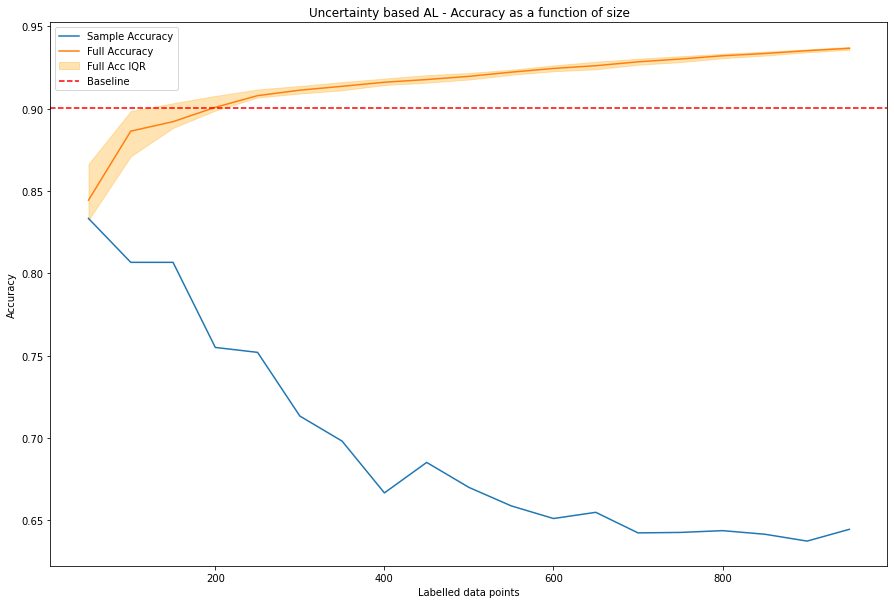

In [112]:
# Plotting
plt.figure(figsize=(15,10))

# Plot average accuracies
plt.plot(accuracies_u_df.reset_index()['index'], accuracies_u_df['Sample Accuracy'], label='Sample Accuracy')
plt.plot(accuracies_u_df.reset_index()['index'], accuracies_u_df['Full Accuracy'], label='Full Accuracy')

# Optional: Plot IQR
#plt.fill_between(accuracies_u_df.reset_index()['index'], stats_sample_u_df['25%'], stats_sample_u_df['75%'], color='blue', alpha=0.3, label='Sample Acc IQR')
plt.fill_between(accuracies_u_df.reset_index()['index'], stats_full_u_df['25%'], stats_full_u_df['75%'], color='orange', alpha=0.3, label='Full Acc IQR')

# Baseline accuracy and other plot settings
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
plt.legend()
plt.title('Uncertainty based AL - Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')
plt.show()

### **Feature Distribution Based Active Learning**

In [129]:
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

tot_accuracies_f = []

for seed in range(1, 11):

    # Initialize sample (stratified)
    non_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    
    step = 50
    accuracies_f = {}

    for size in range(50, 1000, step):
        sample_acc, model, scaler = classificationModel(current_sample, seed=seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(non_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(non_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies_f[size] = [sample_acc, full_acc]
    
        # Dissimilarity based selection
        distances = cdist(non_labelled_df, current_sample, metric='euclidean')
        mean_distances = distances.mean(axis=1)
        dissimilarity_df = pd.DataFrame(mean_distances, index=non_labelled_df.index, columns=['dissimilarity'])
        dissimilar_points = dissimilarity_df.nlargest(step, 'dissimilarity')
        to_be_labelled_dissimilarity = non_labelled_df.loc[dissimilar_points.index]

        current_sample = pd.concat([current_sample, to_be_labelled_dissimilarity])
        non_labelled_df = non_labelled_df.drop(dissimilar_points.index)

    tot_accuracies_f.append(accuracies_f)


In [130]:
list_of_dicts = tot_accuracies_f

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

accuracies_f_df = pd.DataFrame(averages).T
accuracies_f_df.columns = ['Sample Accuracy', 'Full Accuracy']

In [131]:
all_accuracies_f_df = pd.DataFrame.from_records(list_of_dicts)

def compute_stats(df, key, element_index=0):
    max_vals = df[key].apply(lambda x: x[element_index]).max()
    min_vals = df[key].apply(lambda x: x[element_index]).min()
    q25_vals = df[key].apply(lambda x: x[element_index]).quantile(0.25)
    q75_vals = df[key].apply(lambda x: x[element_index]).quantile(0.75)
    return max_vals, min_vals, q25_vals, q75_vals

# Compute stats for sample and full accuracy
stats_sample = {size: compute_stats(all_accuracies_f_df, size, element_index=0) for size in all_accuracies_f_df.columns}
stats_full = {size: compute_stats(all_accuracies_f_df, size, element_index=1) for size in all_accuracies_f_df.columns}

# Convert these stats into DataFrames
stats_sample_f_df = pd.DataFrame(stats_sample, index=['Max', 'Min', '25%', '75%']).T
stats_full_f_df = pd.DataFrame(stats_full, index=['Max', 'Min', '25%', '75%']).T

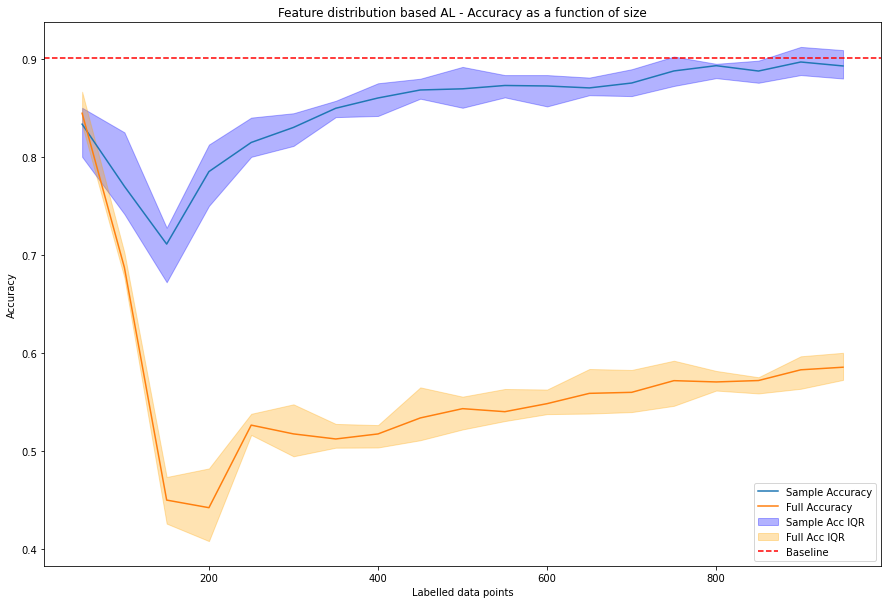

In [132]:
# Plotting
plt.figure(figsize=(15,10))

# Plot average accuracies
plt.plot(accuracies_f_df.reset_index()['index'], accuracies_f_df['Sample Accuracy'], label='Sample Accuracy')
plt.plot(accuracies_f_df.reset_index()['index'], accuracies_f_df['Full Accuracy'], label='Full Accuracy')

# Optional: Plot IQR
plt.fill_between(accuracies_f_df.reset_index()['index'], stats_sample_f_df['25%'], stats_sample_f_df['75%'], color='blue', alpha=0.3, label='Sample Acc IQR')
plt.fill_between(accuracies_f_df.reset_index()['index'], stats_full_f_df['25%'], stats_full_f_df['75%'], color='orange', alpha=0.3, label='Full Acc IQR')

# Baseline accuracy and other plot settings
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
plt.legend()
plt.title('Feature distribution based AL - Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')
plt.show()

### **Feature Distribution and Uncertainty Based Active Learning**

In [117]:
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

tot_accuracies_uf = []

for seed in range(1, 11):

    # Initialize sample (stratified)
    non_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    
    step = 100
    accuracies_uf = {}

    for size in range(50, 10000, step):
        sample_acc, model, scaler = classificationModel(current_sample, seed=seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(non_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(non_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies_uf[size] = [sample_acc, full_acc]

        # Uncertainty based selection
        predicted_proba = model.predict_proba(full_X_train_scaled)
        predicted_proba_df = pd.DataFrame(predicted_proba[:,1], index=non_labelled_df.index)
        predicted_proba_df['uncertainty_diff'] = (0.5 - predicted_proba_df[0]).abs()
        top_50_uncertain_points = predicted_proba_df.nsmallest(step//2, 'uncertainty_diff')
        to_be_labelled_uncertainty = non_labelled_df.loc[top_50_uncertain_points.index]

        current_sample = pd.concat([current_sample, to_be_labelled_uncertainty])
        non_labelled_df = non_labelled_df.drop(top_50_uncertain_points.index)
    
        # Dissimilarity based selection
        distances = cdist(non_labelled_df, current_sample, metric='euclidean')
        mean_distances = distances.mean(axis=1)
        dissimilarity_df = pd.DataFrame(mean_distances, index=non_labelled_df.index, columns=['dissimilarity'])
        dissimilar_points = dissimilarity_df.nlargest(step//2, 'dissimilarity')
        to_be_labelled_dissimilarity = non_labelled_df.loc[dissimilar_points.index]

        current_sample = pd.concat([current_sample, to_be_labelled_dissimilarity])
        non_labelled_df = non_labelled_df.drop(dissimilar_points.index)

    tot_accuracies_uf.append(accuracies_uf)


In [118]:
list_of_dicts = tot_accuracies_uf

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

accuracies_uf_df = pd.DataFrame(averages).T
accuracies_uf_df.columns = ['Sample Accuracy', 'Full Accuracy']

In [119]:
all_accuracies_uf_df = pd.DataFrame.from_records(list_of_dicts)

def compute_stats(df, key, element_index=0):
    max_vals = df[key].apply(lambda x: x[element_index]).max()
    min_vals = df[key].apply(lambda x: x[element_index]).min()
    q25_vals = df[key].apply(lambda x: x[element_index]).quantile(0.25)
    q75_vals = df[key].apply(lambda x: x[element_index]).quantile(0.75)
    return max_vals, min_vals, q25_vals, q75_vals

# Compute stats for sample and full accuracy
stats_sample = {size: compute_stats(all_accuracies_uf_df, size, element_index=0) for size in all_accuracies_uf_df.columns}
stats_full = {size: compute_stats(all_accuracies_uf_df, size, element_index=1) for size in all_accuracies_uf_df.columns}

# Convert these stats into DataFrames
stats_sample_uf_df = pd.DataFrame(stats_sample, index=['Max', 'Min', '25%', '75%']).T
stats_full_uf_df = pd.DataFrame(stats_full, index=['Max', 'Min', '25%', '75%']).T

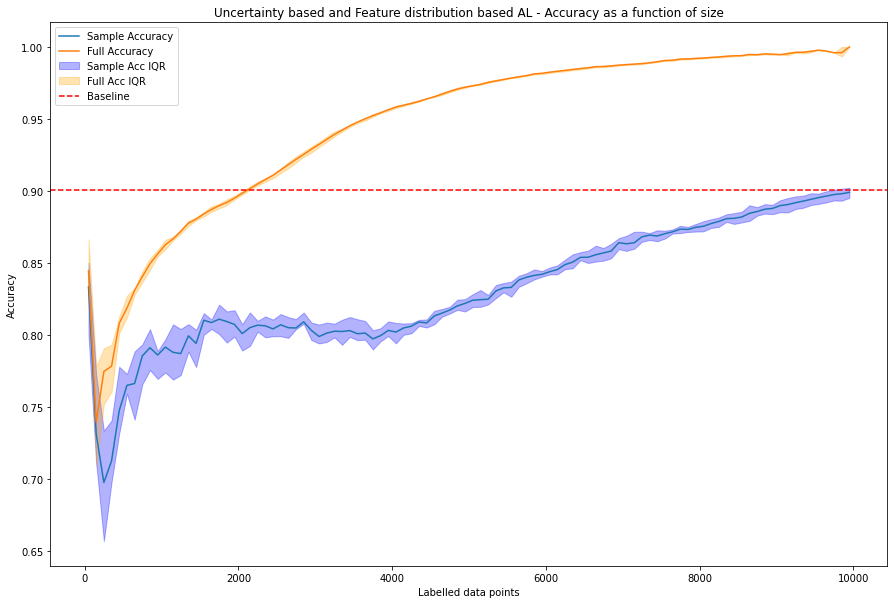

In [122]:
# Plotting
plt.figure(figsize=(15,10))

# Plot average accuracies
plt.plot(accuracies_uf_df.reset_index()['index'], accuracies_uf_df['Sample Accuracy'], label='Sample Accuracy')
plt.plot(accuracies_uf_df.reset_index()['index'], accuracies_uf_df['Full Accuracy'], label='Full Accuracy')

# Optional: Plot IQR
plt.fill_between(accuracies_uf_df.reset_index()['index'], stats_sample_uf_df['25%'], stats_sample_uf_df['75%'], color='blue', alpha=0.3, label='Sample Acc IQR')
plt.fill_between(accuracies_uf_df.reset_index()['index'], stats_full_uf_df['25%'], stats_full_uf_df['75%'], color='orange', alpha=0.3, label='Full Acc IQR')

# Baseline accuracy and other plot settings
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
plt.legend()
plt.title('Uncertainty based and Feature distribution based AL - Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')
plt.show()